In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm


from utils import count_parameters, plot_metrics, plot_ROC, calculate_rocs, plot_ROC_all
from transformer_scratch import Part, JetParticleDataset_part

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC, F1Score

from sklearn.model_selection import train_test_split

from time import time
import gc

In [3]:
print('Preparing data...')
start = time()
        
N = 16         
reverse = ''#'_reversed'
file_path = f'/home/asugu/work/event_data_tt_pad{N}_4mom{reverse}.pkl'

from_checkpoint = True
checkpoint_path = '/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_part_60.pth'

with open(file_path, 'rb') as file:
    event_data = pickle.load(file)
    
df = pd.DataFrame(event_data)

del event_data
gc.collect()


Preparing data...


20

In [4]:
#_______________________________________________________HYPERPARAMETERS_______________________________________________________#
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")  #"mps" if torch.backends.mps.is_available() else "cpu"  

batch_size = 512
n_epochs = 30
learning_rate = 0.001

scheduler_step = 40
scheduler_gamma = 0.8

input_size = N   # padded length
embed_size = 16
n_heads = 8
n_part_layers =8
n_cls_layers = 2

print(f'Selected device: {device}')

Selected device: cuda


In [5]:

model = Part(input_dim=input_size, embed_dim=embed_size, num_heads=n_heads, num_layers=n_part_layers, num_cls_layers=n_cls_layers) 
model= nn.DataParallel(model,device_ids = [0, 1])
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

if from_checkpoint == True:

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_train_loss = checkpoint['train_losses']
    epoch_train_accuracy = checkpoint['train_accuracies']
    epoch_train_auc = checkpoint['train_aucs']
    epoch_train_f1 = checkpoint['train_f1s']
    epoch_val_loss = checkpoint['val_losses']
    epoch_val_accuracy = checkpoint['val_accuracies']
    epoch_val_auc = checkpoint['val_aucs']
    epoch_val_f1 = checkpoint['val_f1s']
    scaler_mean = np.array([-0.125])#checkpoint['scaler_mean']
    scaler_std = np.array([0.59947894])#checkpoint['scaler_std']
    scaler=(scaler_mean, scaler_std) 

    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

else:
    epoch = 0 
    epoch_train_loss = []
    epoch_train_accuracy = []
    epoch_train_auc = []
    epoch_train_f1 = []
    epoch_val_loss = []
    epoch_val_accuracy = []
    epoch_val_auc = []
    epoch_val_f1 = []
    scaler_mean = np.array([-0.125])
    scaler_std = np.array([0.59947894])
    scaler=(scaler_mean, scaler_std) 
    #scaler = StandardScaler()

#model= nn.DataParallel(model,device_ids = [0, 1])
model.to(device)

count_parameters(model)



#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

print("scalr is :", scaler)

+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|              module.cls_token             |     16     |
|        module.embed.input_bn.weight       |     16     |
|         module.embed.input_bn.bias        |     16     |
|        module.embed.embed1.0.weight       |    1024    |
|         module.embed.embed1.0.bias        |     64     |
|        module.embed.embed2.0.weight       |    1024    |
|         module.embed.embed2.0.bias        |     16     |
|       module.pair_embed.conv1.weight      |    512     |
|        module.pair_embed.conv1.bias       |     8      |
|       module.pair_embed.conv2.weight      |    576     |
|        module.pair_embed.conv2.bias       |     8      |
|          module.blocks.0.w_resid          |     16     |
|    module.blocks.0.attn.in_proj_weight    |    768     |
|     module.blocks.0.attn.in_proj_bias     |     48    

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['btag'])

train_dataset = JetParticleDataset_part(train_df, device=device, eval=False,scaler=scaler)
test_dataset = JetParticleDataset_part(test_df, device=device, eval=True,scaler=scaler)

print(len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)      # add workers
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=True)    

print(len(test_dataloader))


1149988
1


In [7]:
del df, train_df, test_df, train_dataset, test_dataset
gc.collect()

finish = time()

print(f"Data preperation took {finish-start} seconds.")

Data preperation took 86.61397910118103 seconds.


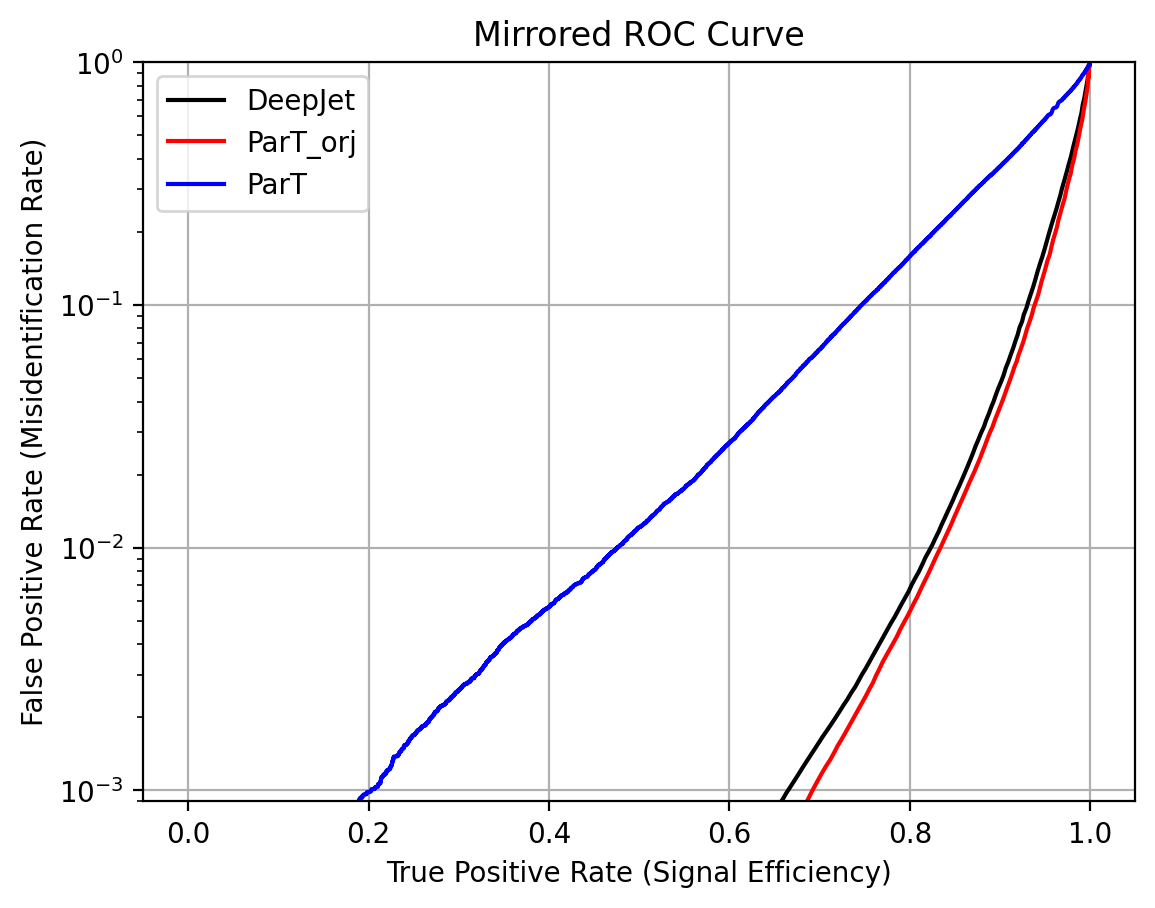

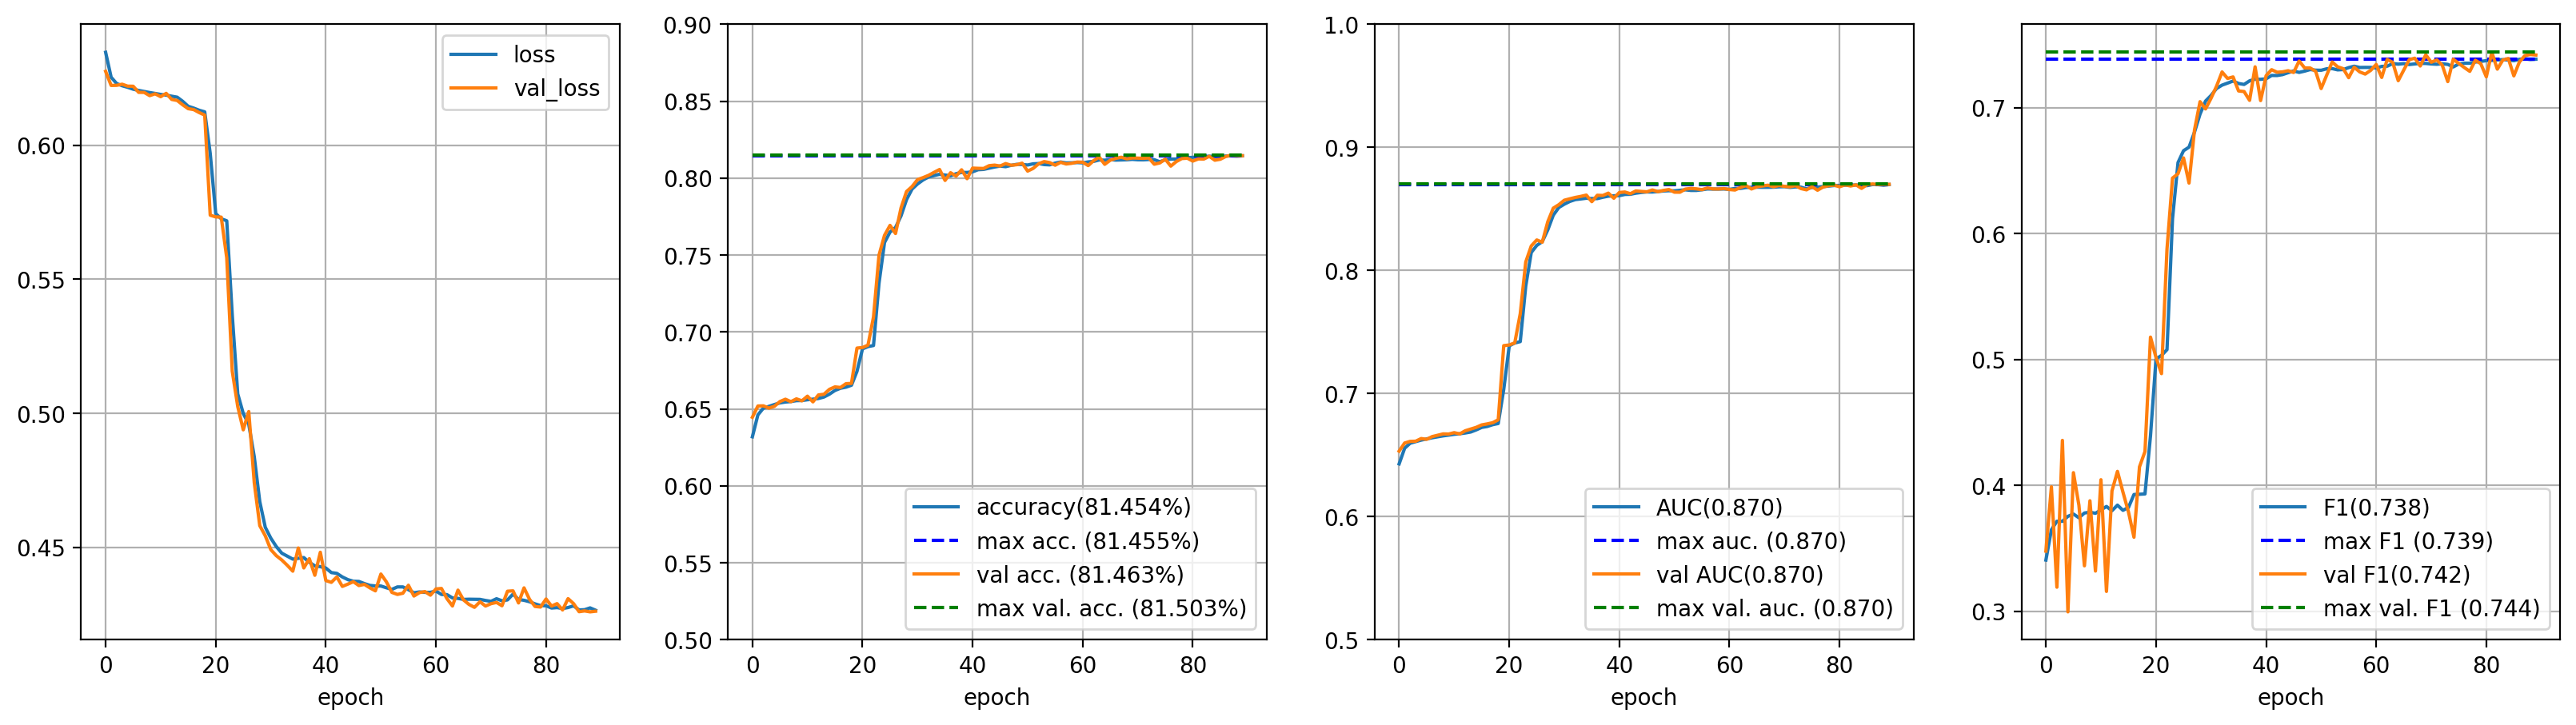

Training: Epoch [90/90] --- Loss: 0.4265 --- Accuracy: 0.8145 --- AUC: 0.870
Test    : Epoch [90/90] --- Loss: 0.4262 --- Accuracy: 0.8146 --- AUC: 0.870


In [8]:
acc_metric = BinaryAccuracy().to(device)
auc_metric = AUROC(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

model.to(device)


for i_epoch in range(n_epochs):

    train_losses = []
    train_accuracies = []
    train_aucs = []
    train_f1s =[]
    val_losses = []
    val_accuracies = []
    val_aucs = []
    val_f1s = []



    lr = optimizer.param_groups[0]['lr']
    print(f'Learning rate was set to {lr:.5f}.')

    model.train()
    for batch_jet_inputs, batch_particle_inputs, batch_four_momenta, batch_labels, _ in tqdm(train_dataloader): 

        particle_inputs = batch_particle_inputs
        jet_inputs = batch_jet_inputs
        four_momenta = batch_four_momenta
        train_label = batch_labels
        
       

        optimizer.zero_grad()
        train_pred = model(particle_inputs,four_momenta,batch_jet_inputs)
        
        loss = criterion(train_pred, train_label)

        if not torch.isnan(loss):  
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        train_accuracy = acc_metric(train_pred, train_label)
        train_accuracies.append(train_accuracy.item())
        train_auc = auc_metric(train_pred, train_label)
        train_aucs.append(train_auc.item())
        train_f1 = f1_metric(train_pred, train_label)
        train_f1s.append(train_f1.item())

#    scheduler.step()

    print('Evaluating metrics...', end='\r')

    model.eval()
    with torch.no_grad():
        for val_jet_inputs, val_particle_inputs, val_four_momenta, val_labels, flavors in test_dataloader: 
            val_preds = model(val_particle_inputs,val_four_momenta,val_jet_inputs)
            val_loss = criterion(val_preds, val_labels)   
            val_losses.append(val_loss.item())
            val_accuracy = acc_metric(val_preds, val_labels)
            val_accuracies.append(val_accuracy.item())
            val_auc = auc_metric(val_preds, val_labels)
            val_aucs.append(val_auc.item())
            val_f1 = f1_metric(val_preds,val_labels)
            val_f1s.append(val_f1.item())
            
            _,_,l_fpr, l_tpr = calculate_rocs(val_preds, val_labels, flavors) #c_fpr, c_tpr, 
        
    plot_ROC(l_fpr.cpu().numpy(),l_tpr.cpu().numpy(),save_path=f'/home/asugu/work/part/roc_graphs/roc_{i_epoch+epoch}') #c_fpr.cpu().numpy(),c_tpr.cpu().numpy(),

    epoch_val_loss.append(sum(val_losses) / len(val_losses))
    epoch_val_accuracy.append(sum(val_accuracies) / len(val_accuracies))
    epoch_val_auc.append(sum(val_aucs) / len(val_aucs))
    epoch_val_f1.append(sum(val_f1s) / len(val_f1s))
             
    epoch_train_loss.append( sum(train_losses) / len(train_losses))
    epoch_train_accuracy.append(sum(train_accuracies) / len(train_accuracies))
    epoch_train_auc.append(sum(train_aucs) / len(train_aucs))
    epoch_train_f1.append(sum(train_f1s) / len(train_f1s))
 
    plot_metrics(np.arange(i_epoch+epoch+1), epoch_train_loss, epoch_val_loss, epoch_train_accuracy, epoch_val_accuracy, epoch_train_auc, epoch_val_auc, epoch_train_f1, epoch_val_f1)

    print('Evaluating metrics finished!', end='\r')
    print(f'Training: Epoch [{i_epoch+epoch + 1}/{n_epochs+epoch}] --- Loss: {epoch_train_loss[-1]:.4f} --- Accuracy: {epoch_train_accuracy[-1]:.4f} --- AUC: {epoch_train_auc[-1]:.3f}\nTest    : Epoch [{i_epoch +epoch + 1}/{n_epochs+epoch}] --- Loss: {epoch_val_loss[-1]:.4f} --- Accuracy: {epoch_val_accuracy[-1]:.4f} --- AUC: {epoch_val_auc[-1]:.3f}\n', end='\r')
    
    torch.cuda.empty_cache()
    del loss, val_loss, train_pred, val_preds
    del train_losses, train_accuracies, train_aucs, train_f1s, val_losses, val_accuracies, val_aucs, val_f1s
    gc.collect()



In [9]:
# Save model checkpoint
checkpoint = {
    'epoch': i_epoch + epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': epoch_train_loss,
    'train_accuracies': epoch_train_accuracy,
    'train_aucs': epoch_train_auc,
    'train_f1s': epoch_train_f1,
    'val_losses': epoch_val_loss,
    'val_accuracies': epoch_val_accuracy,
    'val_aucs': epoch_val_auc,
    'val_f1s': epoch_val_f1,

}

checkpoint_path = f'/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_part_{i_epoch+epoch+1}.pth'
torch.save(checkpoint, checkpoint_path)


In [10]:
print(i_epoch+epoch+1)

90


In [11]:
column_names = ['tpr', 'fpr']
pr = pd.DataFrame({'tpr': l_tpr.cpu(), 'fpr': l_fpr.cpu()})

# Define the file path for saving
output_path = '/home/asugu/work/benchmark/part_bench.csv'

# Save the DataFrame to a CSV file with specified column names
pr.to_csv(output_path, index=False)

In [12]:
#plot_ROC_all()